In [7]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

# System and warnings
import os
import warnings
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline


In [8]:
# Load the dataset
file_path = r"D:\IUBAT\Research\fake review detection\fake reviews dataset.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to verify loading
df.head()



,category,rating,label,text
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [9]:
print(df.columns.tolist())


['category', 'rating', 'label', 'text']


In [ ]:
df

,category,rating,label,text
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1,CG,I liked nothing about this dress. The only rea...


In [11]:
# Show missing value counts
print("Missing values before cleaning:")
print(df.isnull().sum())

# Drop rows where the review text or label is missing (those are critical)
df.dropna(subset=['text', 'label'], inplace=True)

# For categorical features like user_id or username, fill with 'unknown'
for col in df.select_dtypes(include='object'):
    if col != 'text':  # don't alter review text
        df[col].fillna('unknown', inplace=True)

# For numeric columns like rating, fill with median
for col in df.select_dtypes(include=['int64', 'float64']):
    df[col].fillna(df[col].median(), inplace=True)

# Confirm missing values handled
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
category    0
rating      0
label       0
text        0
dtype: int64

Missing values after cleaning:
category    0
rating      0
label       0
text        0
dtype: int64


In [12]:
#Understanding the text characteristics
df['review_length'] = df['text'].apply(lambda x: len(x.split()))
print(df['review_length'].describe())
print(df.groupby('label')['review_length'].describe())

count    40432.000000
mean        67.455926
std         69.572455
min          1.000000
25%         21.000000
50%         39.000000
75%         85.000000
max        373.000000
Name: review_length, dtype: float64
         count       mean        std  min   25%   50%   75%    max
label                                                             
CG     20216.0  61.282351  61.796955  1.0  19.0  35.0  77.0  318.0
OR     20216.0  73.629501  76.064439  1.0  23.0  42.0  93.0  373.0


In [13]:
#Data Cleaning
import re

# Define nltk and download necessary data files
try:
    import nltk
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install nltk
    import nltk

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#define a function to remove special characters, numbers, and convert to lower case
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower() 
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

#Remove whitespaces that might occur from the cleaning
df['cleaned_text'] = df['cleaned_text'].str.strip()
df['cleaned_text'] = df['cleaned_text'].str.replace(r'\s+', ' ', regex=True)

print(df['cleaned_text'].head())

# Tokenization
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

print(df[['text', 'cleaned_text', 'tokens']])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shuchuna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shuchuna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Shuchuna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    love well made sturdy comfortable love itvery ...
1    love great upgrade original ive mine couple years
2              pillow saved back love look feel pillow
3          missing information use great product price
4                 nice set good quality set two months
Name: cleaned_text, dtype: object
                                                    text  \
0      Love this!  Well made, sturdy, and very comfor...   
1      love it, a great upgrade from the original.  I...   
2      This pillow saved my back. I love the look and...   
3      Missing information on how to use it, but it i...   
4      Very nice set. Good quality. We have had the s...   
...                                                  ...   
40427  I had read some reviews saying that this bra r...   
40428  I wasn't sure exactly what it would be. It is ...   
40429  You can wear the hood by itself, wear it with ...   
40430  I liked nothing about this dress. The only rea...   
40431  I work in the wedding in

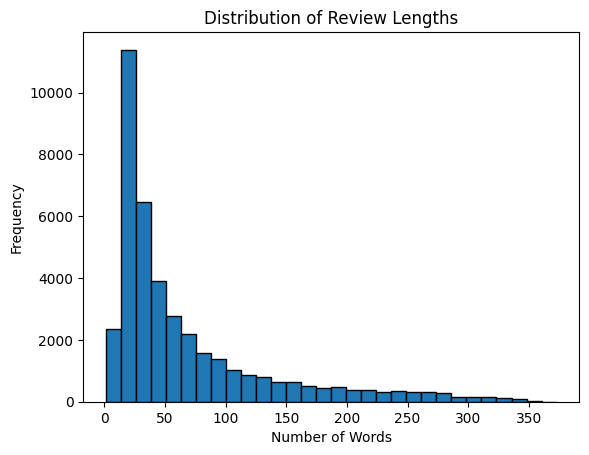

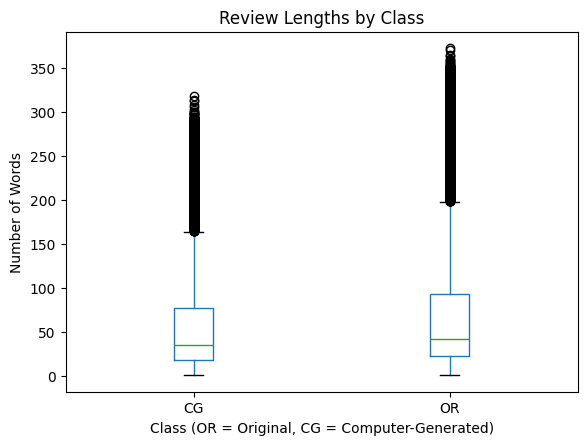

Most Common Words in Real Reviews:
[('one', 6808), ('great', 5774), ('like', 5241), ('book', 5218), ('good', 4742), ('would', 4325), ('well', 4218), ('love', 3941), ('really', 3534), ('get', 3524)]

Most Common Words in Fake Reviews:
[('great', 10644), ('book', 9781), ('good', 9451), ('love', 6860), ('story', 6761), ('one', 6583), ('well', 6061), ('would', 6036), ('read', 5606), ('little', 5318)]


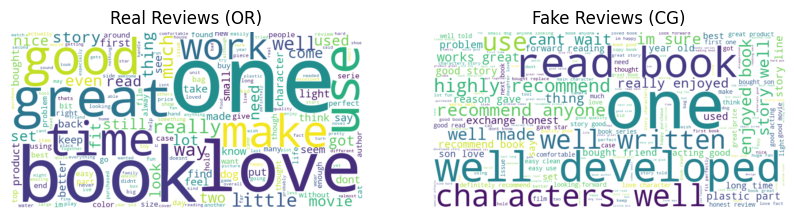

In [14]:
#EDA
import matplotlib.pyplot as plt
from collections import Counter

# Check if wordcloud is installed, if not, install it
try:
    from wordcloud import WordCloud
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install wordcloud
    from wordcloud import WordCloud

# Check if textblob is installed, if not, install it
try:
    from textblob import TextBlob
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install textblob
    from textblob import TextBlob

# Distribution of Review Lengths
plt.hist(df['review_length'], bins=30, edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Review Lengths by Class
df.boxplot(column='review_length', by='label', grid=False)
plt.title('Review Lengths by Class')
plt.suptitle('')  # Remove default title
plt.xlabel('Class (OR = Original, CG = Computer-Generated)')
plt.ylabel('Number of Words')
plt.show()

# Word Frequency Analysis
# Combine text by class
or_text = ' '.join(df[df['label'] == 'OR']['cleaned_text'])
cg_text = ' '.join(df[df['label'] == 'CG']['cleaned_text'])

# Count most common words
or_word_counts = Counter(or_text.split())
cg_word_counts = Counter(cg_text.split())

print("Most Common Words in Real Reviews:")
print(or_word_counts.most_common(10))

print("\nMost Common Words in Fake Reviews:")
print(cg_word_counts.most_common(10))

# Word Clouds 
# Generate word clouds
or_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(or_text)
cg_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cg_text)

# Display word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Real Reviews (OR)')
plt.imshow(or_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Fake Reviews (CG)')
plt.imshow(cg_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# For example, 'genuine' might become 0, and 'fake' becomes 1
print(le.classes_)  # to see original class mapping


['CG' 'OR']


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform text data
X = tfidf.fit_transform(df['text'])

# Target variable
y = df['label']


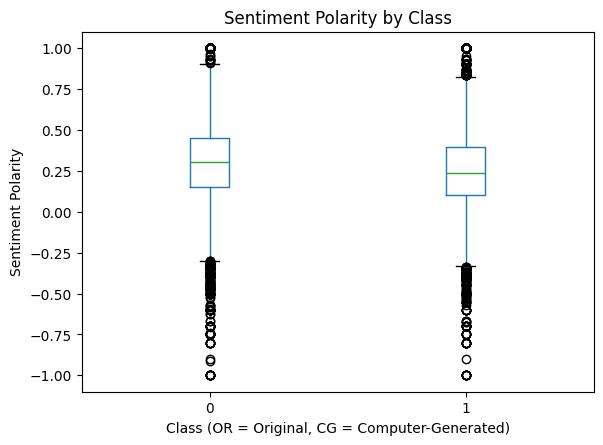

Shortest Reviews:
                                            cleaned_text  label
21686                                               well      0
37326                                               name      1
37914                                                         0
36832                                 nice elegant watch      0
5675   div idvideoblockrsgifcacnuwea classasection as...      0

Longest Reviews:
                                            cleaned_text  label
15543  movies moods tastes occasions emphasize dialog...      1
4045   interest pan satisfy longing perfect easy egg ...      1
15575  ecw extreme evolution never seen ecw buying th...      1
15531  going first importantly season three scoobydoo...      1
11985  camera dxo labs gave following rating need sus...      1


In [17]:
#Sentiment Analysis
# Calculate sentiment polarity (-1 = negative, 1 = positive)
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Boxplot of sentiment by class
df.boxplot(column='sentiment', by='label', grid=False)
plt.title('Sentiment Polarity by Class')
plt.suptitle('')
plt.xlabel('Class (OR = Original, CG = Computer-Generated)')
plt.ylabel('Sentiment Polarity')
plt.show()

# Outlier Analysis 
# Shortest reviews
print("Shortest Reviews:")
print(df.nsmallest(5, 'review_length')[['cleaned_text', 'label']])

# Longest reviews
print("\nLongest Reviews:")
print(df.nlargest(5, 'review_length')[['cleaned_text', 'label']])

In [18]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define tokenizer with lemmatization and stopword removal
def spacy_tokenizer(text):
    doc = nlp(text.lower())  # Lowercase
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens


In [ ]:
# Convert feature label to numeric
df['label_numeric'] = df['label'].map({'CG': 0, 'OR': 1})

# Print the features
print(df[['text', 'label', 'label_numeric']].head())

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", X.shape)




                                                text  label  label_numeric
0  Love this!  Well made, sturdy, and very comfor...      0            NaN
1  love it, a great upgrade from the original.  I...      0            NaN
2  This pillow saved my back. I love the look and...      0            NaN
3  Missing information on how to use it, but it i...      0            NaN
4  Very nice set. Good quality. We have had the s...      0            NaN
TF-IDF matrix shape: (40432, 5000)


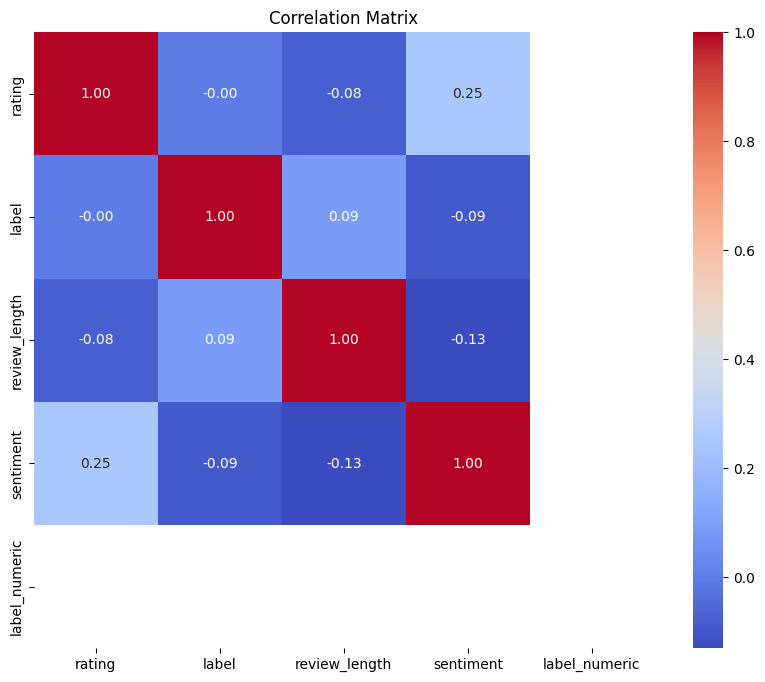

In [20]:
import seaborn as sns

# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()



In [21]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Dictionary to store the evaluation metrics for each model
evaluation_results = {}

# Iterate over each model, fit it, and evaluate
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Store the results
    evaluation_results[model_name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# Print the evaluation results
for model_name, metrics in evaluation_results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print()


Model: Random Forest
  Accuracy: 0.8358
  F1 Score: 0.8357
  Precision: 0.8372
  Recall: 0.8358

Model: XGBoost
  Accuracy: 0.8318
  F1 Score: 0.8316
  Precision: 0.8333
  Recall: 0.8318

Model: Logistic Regression
  Accuracy: 0.8614
  F1 Score: 0.8613
  Precision: 0.8616
  Recall: 0.8614



In [24]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Perform cross-validation and hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(estimator=models["Random Forest"], param_grid=rf_param_grid, 
                              cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
rf_grid_search.fit(X_train, y_train)

# Update the Random Forest model with the best parameters
models["Random Forest"] = rf_grid_search.best_estimator_

# Perform cross-validation for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Re-evaluate the models with the updated Random Forest
evaluation_results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    evaluation_results[model_name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# Print the updated evaluation results
for model_name, metrics in evaluation_results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print()


Random Forest Cross-Validation Accuracy: 0.8349 ± 0.0039
XGBoost Cross-Validation Accuracy: 0.8271 ± 0.0038
Logistic Regression Cross-Validation Accuracy: 0.8587 ± 0.0039
Model: Random Forest
  Accuracy: 0.8435
  F1 Score: 0.8434
  Precision: 0.8445
  Recall: 0.8435

Model: XGBoost
  Accuracy: 0.8318
  F1 Score: 0.8316
  Precision: 0.8333
  Recall: 0.8318

Model: Logistic Regression
  Accuracy: 0.8614
  F1 Score: 0.8613
  Precision: 0.8616
  Recall: 0.8614



In [25]:
# Calculate ROC AUC for each model
roc_auc_results = {}
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_results[model_name] = roc_auc

# Print the ROC AUC results
print("ROC AUC Scores:")
for model_name, roc_auc in roc_auc_results.items():
    print(f"Model: {model_name} - ROC AUC: {roc_auc:.4f}")


NameError: name 'roc_auc_score' is not defined

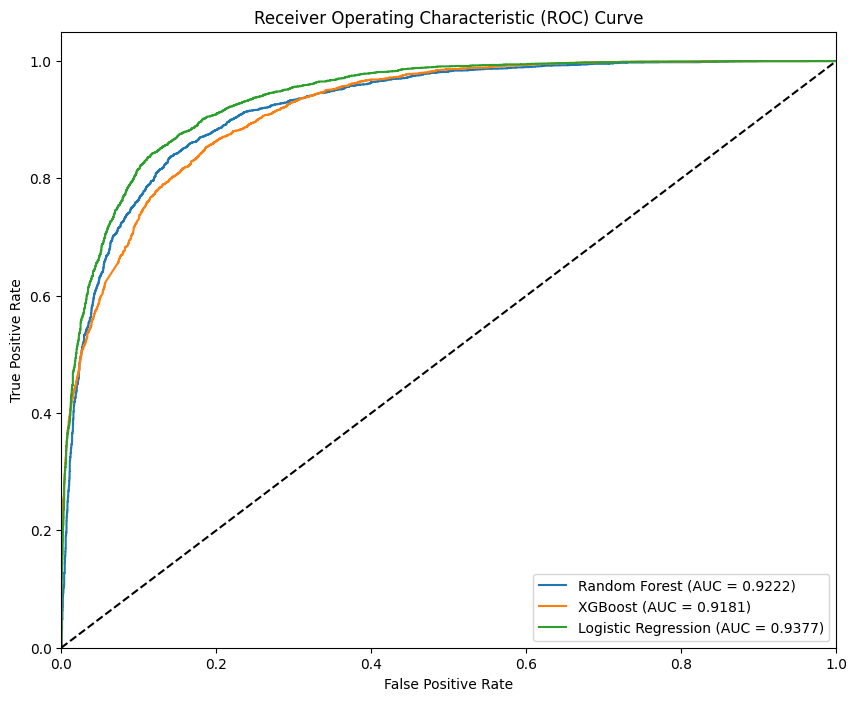

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Plot ROC Curve for each model
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_results[model_name]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [31]:
import pandas as pd

# Create a DataFrame to display the ROC AUC results in a horizontal table format
roc_auc_df = pd.DataFrame(roc_auc_results, index=['ROC AUC'])

# Display the table
print("\nROC AUC Scores in Horizontal Table Format:")
print(roc_auc_df.to_string(index=True))




ROC AUC Scores in Horizontal Table Format:
         Random Forest   XGBoost  Logistic Regression
ROC AUC       0.922215  0.918081             0.937669


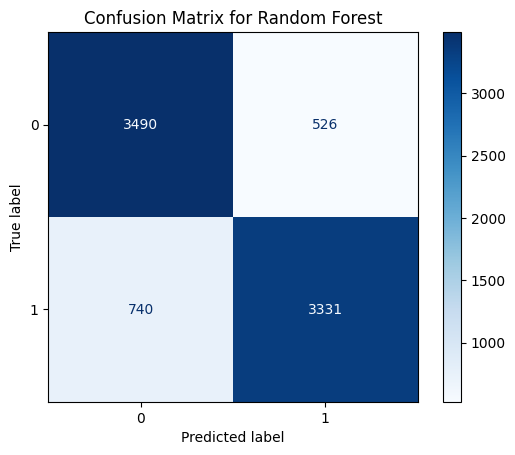

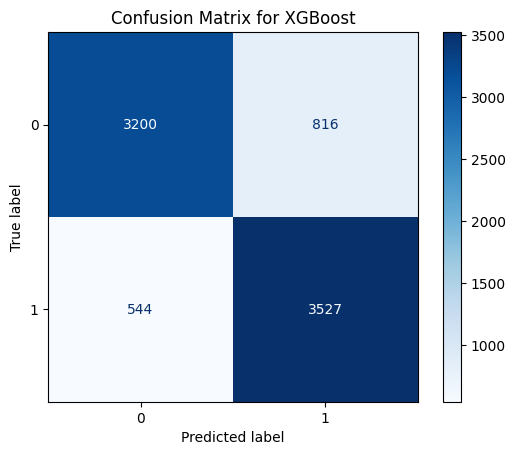

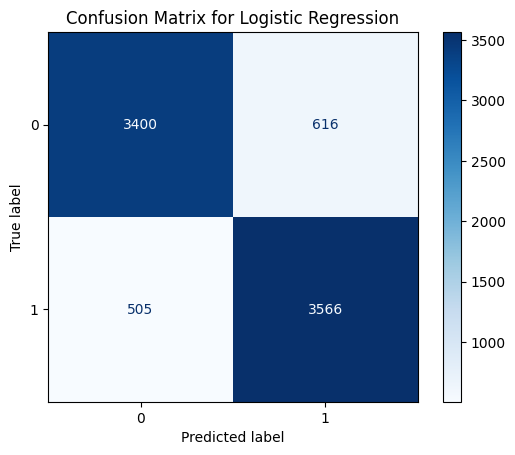

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate and plot confusion matrix for each model
for model_name, model in models.items():
    # Generate predictions for the test set
    y_pred = model.predict(X_test)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()




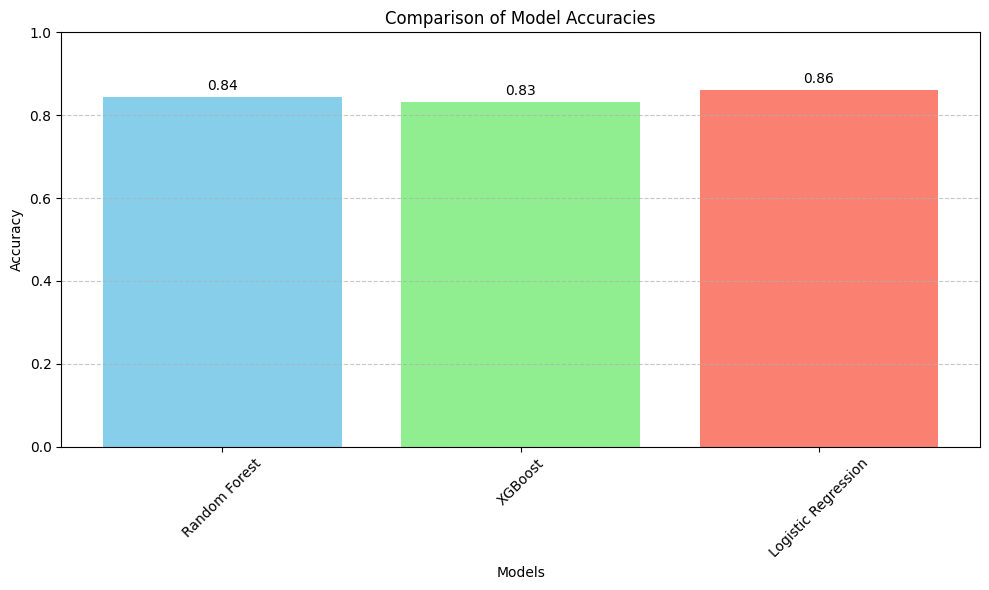

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `models` is a dictionary with model names as keys and their trained model objects as values
# Calculate accuracy for each model
accuracy_results = {model_name: model.score(X_test, y_test) for model_name, model in models.items()}

# Extract model names and their corresponding accuracy scores
model_names = list(accuracy_results.keys())
accuracy_scores = list(accuracy_results.values())

# Create a bar chart to compare model accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the accuracy scores on top of the bars
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

